In [15]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy import signal
# from numpy.random import Generator, MT19937

# sns.set_theme()
plt.rcParams["font.family"] = 'Hiragino sans'
# sns.set(font=['Hiragino sans'])

In [16]:
def RungeKutta4(initial, time, model, F):
    """
    Parameters
    ----------
    F : 
        Forcing constant, variable used in L96
    """
    dt = time[1] - time[0]
    states = [initial]
    x = initial
    for t in time[:-1]:
        k1 = model(x, F)
        x1 = x + k1 * dt/2
        k2 = model(x1, F)
        x2 = x + k2 * dt/2
        k3 = model(x2, F)
        x3 = x + k3 * dt
        k4 = model(x3, F)
        x = x + (k1 + 2*k2 + 2*k3 + k4) * dt / 6
        states.append(x)
    states = np.stack(states)
    return states

def RK4(x, dt, model, F):
    """
    Parameters
    ----------
    F : 
        Forcing constant, variable used in L96
    """
    k1 = model(x, F)
    x1 = x + k1 * dt/2
    k2 = model(x1, F)
    x2 = x + k2 * dt/2
    k3 = model(x2, F)
    x3 = x + k3 * dt
    k4 = model(x3, F)
    return x + (k1 + 2*k2 + 2*k3 + k4) * dt / 6

def L96(x, F):
    """
    Lorenz 96 model with constant forcing.
    Cited by "https://en.wikipedia.org/wiki/Lorenz_96_model"
    
    Parameters
    ----------
    x : 
        variables
    F :
       Forcing constant 
    N : int
        number of sites
    """
    N = 40
    # Setting up vector
    d = np.zeros(N, dtype=np.float_)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d


def simulatior(time_step=0.01):
    N = 40
    F = 8.0
    ratio = 0.001
    year = 2
#     time_step = 0.01
    total_step = 0.2 * 365 * year
    time = np.arange(0.0, total_step + time_step, time_step, dtype=float)

    x = np.full(N, F, dtype=np.float_)
    x[19] += F * ratio
    dat = RungeKutta4(x, time, L96, F=F)

## Load Data  
dt=0.01で良いならば、以下のpickle load  
dt=0.001等としたい時は、run simulator()

In [17]:
with open("../task34/RK4_GeneratedData.pkl", "rb") as f:
    origin = pickle.load(f)    
with open("../task34/NormalNoise.pkl", "rb") as f:
    noise = pickle.load(f)
    
# dat = simulatior(0.001)
# seed = 46
# rg = Generator(MT19937(seed))
# # ノイズとして加える正規分布
# noise = rg.standard_normal(dat.shape)

In [18]:
"""
一年分のstep回数は以下の計算式だから、
後半1年分をとる。
datのtims_stepは0.01刻み
"""
obs_dat = origin + noise
time_step = 0.01
total_step = int(0.2 * 365 / time_step)
origin = origin[total_step:, :]
obs_dat = obs_dat[total_step:, :]

# 0.05=6(h)ごとのデータを抽出
t = int(0.05 / time_step)
six_hour = np.arange(0, len(obs_dat), t, dtype=int)
origin = origin[six_hour, :]
obs_dat = obs_dat[six_hour, :]

In [19]:
print(obs_dat.shape)
obs_dat.dtype = np.float_

(1461, 40)


In [20]:
obs_dat.dtype

dtype('float64')

### データのplot

Text(0.5, 1.0, 'ある地点の、元データとノイズを加えた観測データ（一年分)')

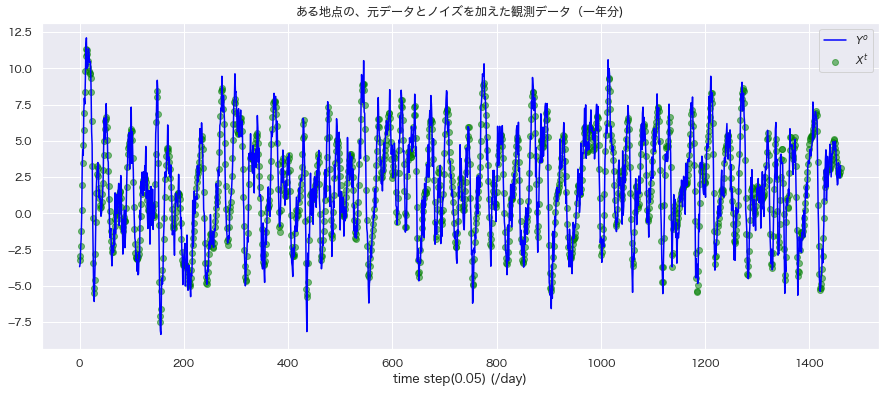

In [21]:
# ある観測地点のplot
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(obs_dat[:, 1], label="$Y^o$", color="blue")
# ax.scatter(range(len(obs_dat[:, 1])), obs_dat[:, 1], label="$Y^o$", alpha=0.5, color="blue")
# ax.plot(origin[:, 1], label="original", label="original", color="green")
ax.scatter(range(len(origin[:, 1])), origin[:, 1], label="$X^t$", color="green", alpha=0.5)
ax.legend()
ax.set_xlabel("time step(0.05) (/day)")
ax.set_title("ある地点の、元データとノイズを加えた観測データ（一年分)")

## KM

In [22]:
# 変数
N = 40
I = np.identity(N, dtype=np.float_)
H = np.identity(N, dtype=np.float_)
R = np.identity(N, dtype=np.float_)
# ajpha 共分散膨張　　↓色々変えてみる
alpha = 1.
delta = 1e-8
dt = 0.05

In [23]:
def tangentM(delta, x_a, dt=0.05, N=40):
    """
    M（RK4)の一次線形近似計算
    
    Parameter
    ---------
    delta : 
        Mの接線形近似のパラメタ
    x_a : 
    dt :
        Mの接線形近似のパラメタ
    N :
        観測点の個数
    """
    TLM = np.zeros((N, N), dtype=np.float_)
    for i in range(N):
        e_i = np.zeros(N, dtype=np.float_)
        e_i[i] = 1
        TLM[:, i] = (RK4(x_a + delta * e_i, dt, L96, 8) - RK4(x_a, dt, L96, 8)) / delta
    return TLM

In [24]:
def one_shotKF(x_a, P_a, y_o, alpha=1.1, delta=1e-8, dt=0.05, I=I, H=H, R=R):
    """
    KFの一回単位のシミュレーション。
    
    Parameter
    ---------
    x_a : 
    P_a :
    y_o :
    alpha :
        共分散膨張率
    delta : 
        Mの接線形近似のパラメタ
    dt : 0.05
        RK4のtime step。
    I :
    H :
    R :
    
    Return
    ------
    x_a, P_a
    """
    M = tangentM(delta, x_a)
    x_f = RK4(x_a, dt, model=L96, F=8)
    P_f = M @ P_a @ M.T
    P_f = P_f * alpha
    K = P_f @ H.T @ np.linalg.inv(H @ P_f @ H.T + R)
    x_a = x_f + K @ (y_o - H @ x_f)
    P_a = P_f - K @ H @ P_f
    return x_a, P_a

In [25]:
"""
初期設定
    x^f_0 = x^a_0 = y^o_0
    P_a = 1
"""
alpha = 1.1
x_f = obs_dat[0, :]
x_a = x_f
P_a = np.identity(N, dtype=np.float_)

# KF simulation
x_analyze = [x_a]
for i in range(1, len(obs_dat)):
    y_o = obs_dat[i, :]
    x_a, P_a = one_shotKF(x_a, P_a, y_o, alpha=alpha)
    x_analyze.append(x_a)
x_analyze = np.stack(x_analyze)

Text(0.5, 1.0, 'ある地点での解析結果(1400stepまで)')

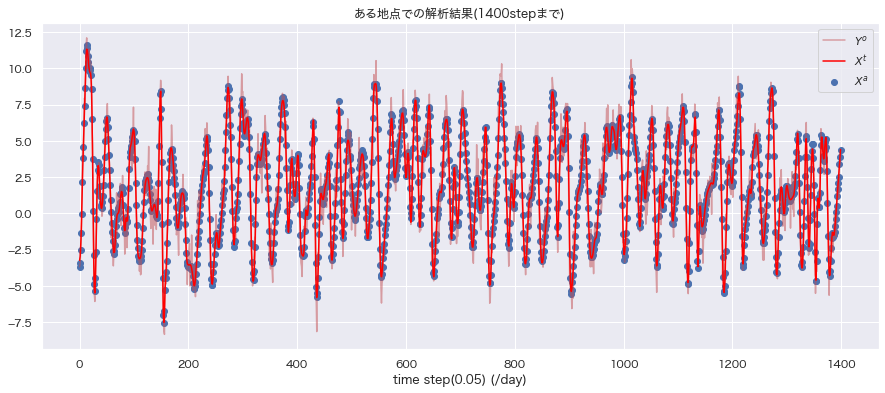

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
length = 1400
ax.scatter(range(len(x_analyze[:length, 1])), x_analyze[:length, 1], label="$X^a$")
# ax.plot(x_analyze[:500, 1])
ax.plot(obs_dat[:length, 1], alpha=0.5, color='r', label="$Y^o$")
ax.plot(origin[:length, 1], label="$X^t$", color="red")
ax.legend()
ax.set_xlabel("time step(0.05) (/day)")
ax.set_title(f"ある地点での解析結果({length}stepまで)")

## MSE

In [27]:
err = np.power(x_analyze - origin, 2).sum(axis=1) / 40
noise_err = np.power(noise, 2).sum(axis=1) / 40

Text(0.5, 1.0, '各time stepでの平均二乗誤差')

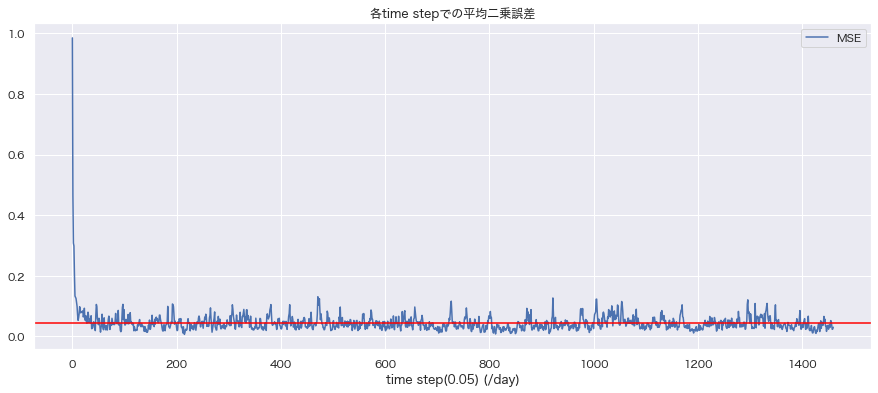

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(err, label="MSE")
ax.axhline(np.average(err), color="red")
# ax.plot(noise_err[six_hour], label="noise MSE")
ax.legend()
ax.set_xlabel("time step(0.05) (/day)")
ax.set_title("各time stepでの平均二乗誤差")